# Importing Libraries

In [1]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings

In [3]:
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

# Read Datasets

The sales data obtained from the Society of Manufacturers of Electric Vehicles, spanning 2017 to 2023, catalogues sales figures of electric two-wheelers, three-wheelers, four-wheelers, and buses. This dataset provides a comprehensive view of market trends and customer preferences over time.

In [4]:
data_smev = pd.read_excel("smev_data.xlsx", sheet_name=None)

In [5]:
data_smev.keys()

dict_keys(['EV 2W FY 19-20', 'EV 2W FY 20-21', 'EV 2W FY 21-22', 'EV 2W FY 22-23', 'EV Market', 'Electric Bus Sales', 'Electric 4-Wheeler Sales', 'Electric 3-Wheeler Sales', 'Electric 2-Wheeler Sales', 'EV Industries'])

In [6]:
data_smev['EV Industries']

,category,financial_year,num_vehicles
0,E-2 Wheelers,2017-18,1981
1,E-2 Wheelers,2018-19,27478
2,E-2 Wheelers,2019-20,26512
3,E-2 Wheelers,2020-21,44294
4,E-2 Wheelers,2021-22,249615
5,E-2 Wheelers,2022-23,728090
6,E-3 Wheelers,2017-18,91970
7,E-3 Wheelers,2018-19,116031
8,E-3 Wheelers,2019-20,143051
9,E-3 Wheelers,2020-21,90898


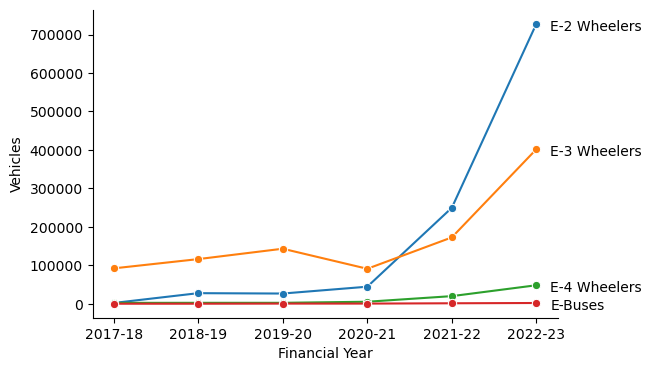

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data=data_smev['EV Industries'], x='financial_year', y='num_vehicles', hue='category', marker='o', palette='tab10')
plt.xlabel("Financial Year")
plt.ylabel("Vehicles")
plt.legend(title='Category')

# Annotate the last data point
for col in data_smev['EV Industries']['category'].unique():
    last_point = data_smev['EV Industries'][data_smev['EV Industries']['category'] == col].iloc[-1]
    plt.annotate(f"{last_point['category']}", 
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5), 
                 ha='left')
ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().set_visible(False)
plt.show()

Above Figure showcased the remarkable growth trajectory of India's two-wheeler market in 2023, underscoring its leading position within the industry.

In [8]:
data_smev['EV Market'] = data_smev['EV Market'].sort_values('Amount INR Cr', ascending = False)

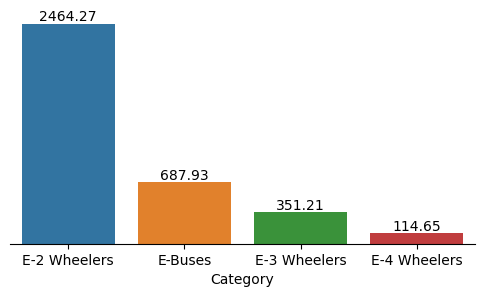

In [9]:
fig, ax = plt.subplots(figsize = (6, 3))
ax = sns.barplot(data_smev['EV Market'], x = 'Category', y = 'Amount INR Cr')
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.ylabel("")
ax.spines[['right', 'top', 'left']].set_visible(False)
plt.show()

Above Figure delved into the market's financial perspective, representing the industry's total value in crores. Notably, two-wheelers emerged as the primary revenue generators, highlighting their economic significance.

In [10]:
ev2w = list(data_smev.keys())[0:4]
data_ev2w = pd.concat([data_smev[ev2w[0]], data_smev[ev2w[1]], data_smev[ev2w[2]], data_smev[ev2w[3]]])

In [11]:
data_ev2w['maker'] = data_ev2w['maker'].str.upper()

In [12]:
np.sort(data_ev2w['maker'].unique())

array(['AMPERE', 'AMPERE VEHICLES', 'ATHER', 'ATHER ENERGY', 'BAJAJ',
       'BEING INDIA', 'BENLING', 'HERO ELECTRIC', 'JITENDRA',
       'JITENDRA NEW EV', 'OKAYA EV', 'OKINAWA', 'OKINAWA AUTOTECH',
       'OLA ELECTRIC', 'OTHERS', 'PURE EV', 'REVOLT', 'TVS'], dtype=object)

In [13]:
data_ev2w['maker'] = data_ev2w['maker'].replace('AMPERE VEHICLES', 'AMPERE').replace('ATHER ENERGY', 'ATHER').replace('BEING INDIA', 'BENLING').replace('JITENDRA NEW EV', 'JITENDRA').replace('OKINAWA AUTOTECH', 'OKINAWA')

In [14]:
np.sort(data_ev2w['maker'].unique())

array(['AMPERE', 'ATHER', 'BAJAJ', 'BENLING', 'HERO ELECTRIC', 'JITENDRA',
       'OKAYA EV', 'OKINAWA', 'OLA ELECTRIC', 'OTHERS', 'PURE EV',
       'REVOLT', 'TVS'], dtype=object)

In [15]:
data_ev2w

,financial_year,maker,market_share,month,num_vehicles
0,2019-20,HERO ELECTRIC,0.30,Apr,1776
1,2019-20,HERO ELECTRIC,0.30,May,455
2,2019-20,HERO ELECTRIC,0.30,Jun,329
3,2019-20,HERO ELECTRIC,0.30,Jul,260
4,2019-20,HERO ELECTRIC,0.30,Aug,249
...,...,...,...,...,...
151,2022-23,OTHERS,0.08,Nov,5241
152,2022-23,OTHERS,0.08,Dec,5233
153,2022-23,OTHERS,0.08,Jan,5111
154,2022-23,OTHERS,0.08,Feb,5083


In [16]:
data_ev2w_year = data_ev2w.groupby(['financial_year', 'maker']).agg({'num_vehicles':'sum'}).reset_index()

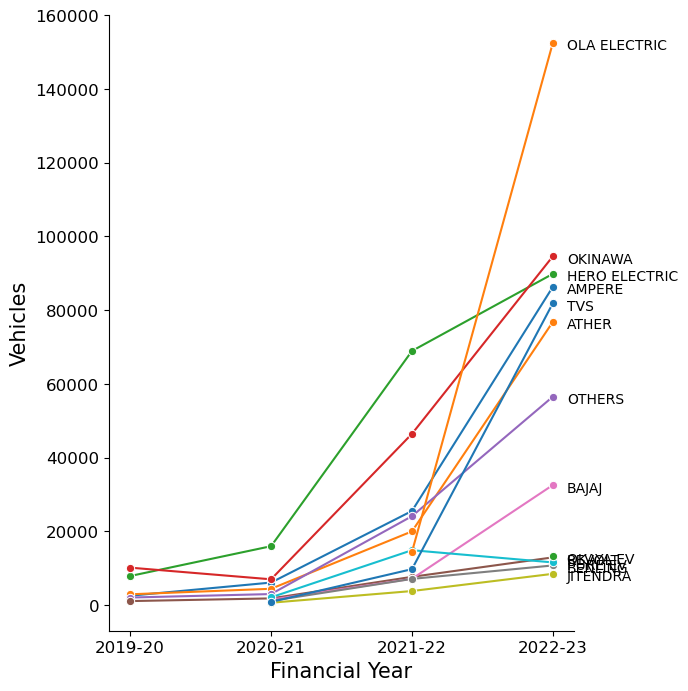

In [17]:
fig, ax = plt.subplots(figsize=(6,8))
ax = sns.lineplot(data=data_ev2w_year, x='financial_year', y='num_vehicles', hue='maker', marker='o', palette='tab10')
plt.xlabel("Financial Year", fontsize = 15)
plt.ylabel("Vehicles", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(title='Maker')

# Annotate the last data point
for col in data_ev2w_year['maker'].unique()[::1]:
    last_point = data_ev2w_year[data_ev2w_year['maker'] == col].iloc[-1]
    plt.annotate(f"{last_point['maker']}", 
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5), 
                 ha='left')
    ax.spines[['right', 'top']].set_visible(False)
ax.get_legend().set_visible(False)
plt.show()


Above Figure honed in on specific electric two-wheeler companies, with Ola Electric emerging as the market leader in 2023, illustrating industry leadership and market competitiveness.

# EV Market Segmentation

The dataset used for the market segmentation analysis, extracted from bikewale.com, comprises electric two-wheeler customer reviews, offering vital behavioral and psychographic insights.
It also presents detailed technical specifications and pricing information of electric two-wheelers. This data allowed us to assess the technical feasibility and price points crucial for our market segmentation strategy

In [18]:
data_bw = pd.read_csv("ev2_bikewale.csv")
data_model = pd.read_csv("ev_model_spec.csv")

In [19]:
data = data_bw.merge(data_model, how = 'left', on = 'Model Name')

In [20]:
data.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W)
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube,137890,100,78,117,5,3000
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000


<Axes: >

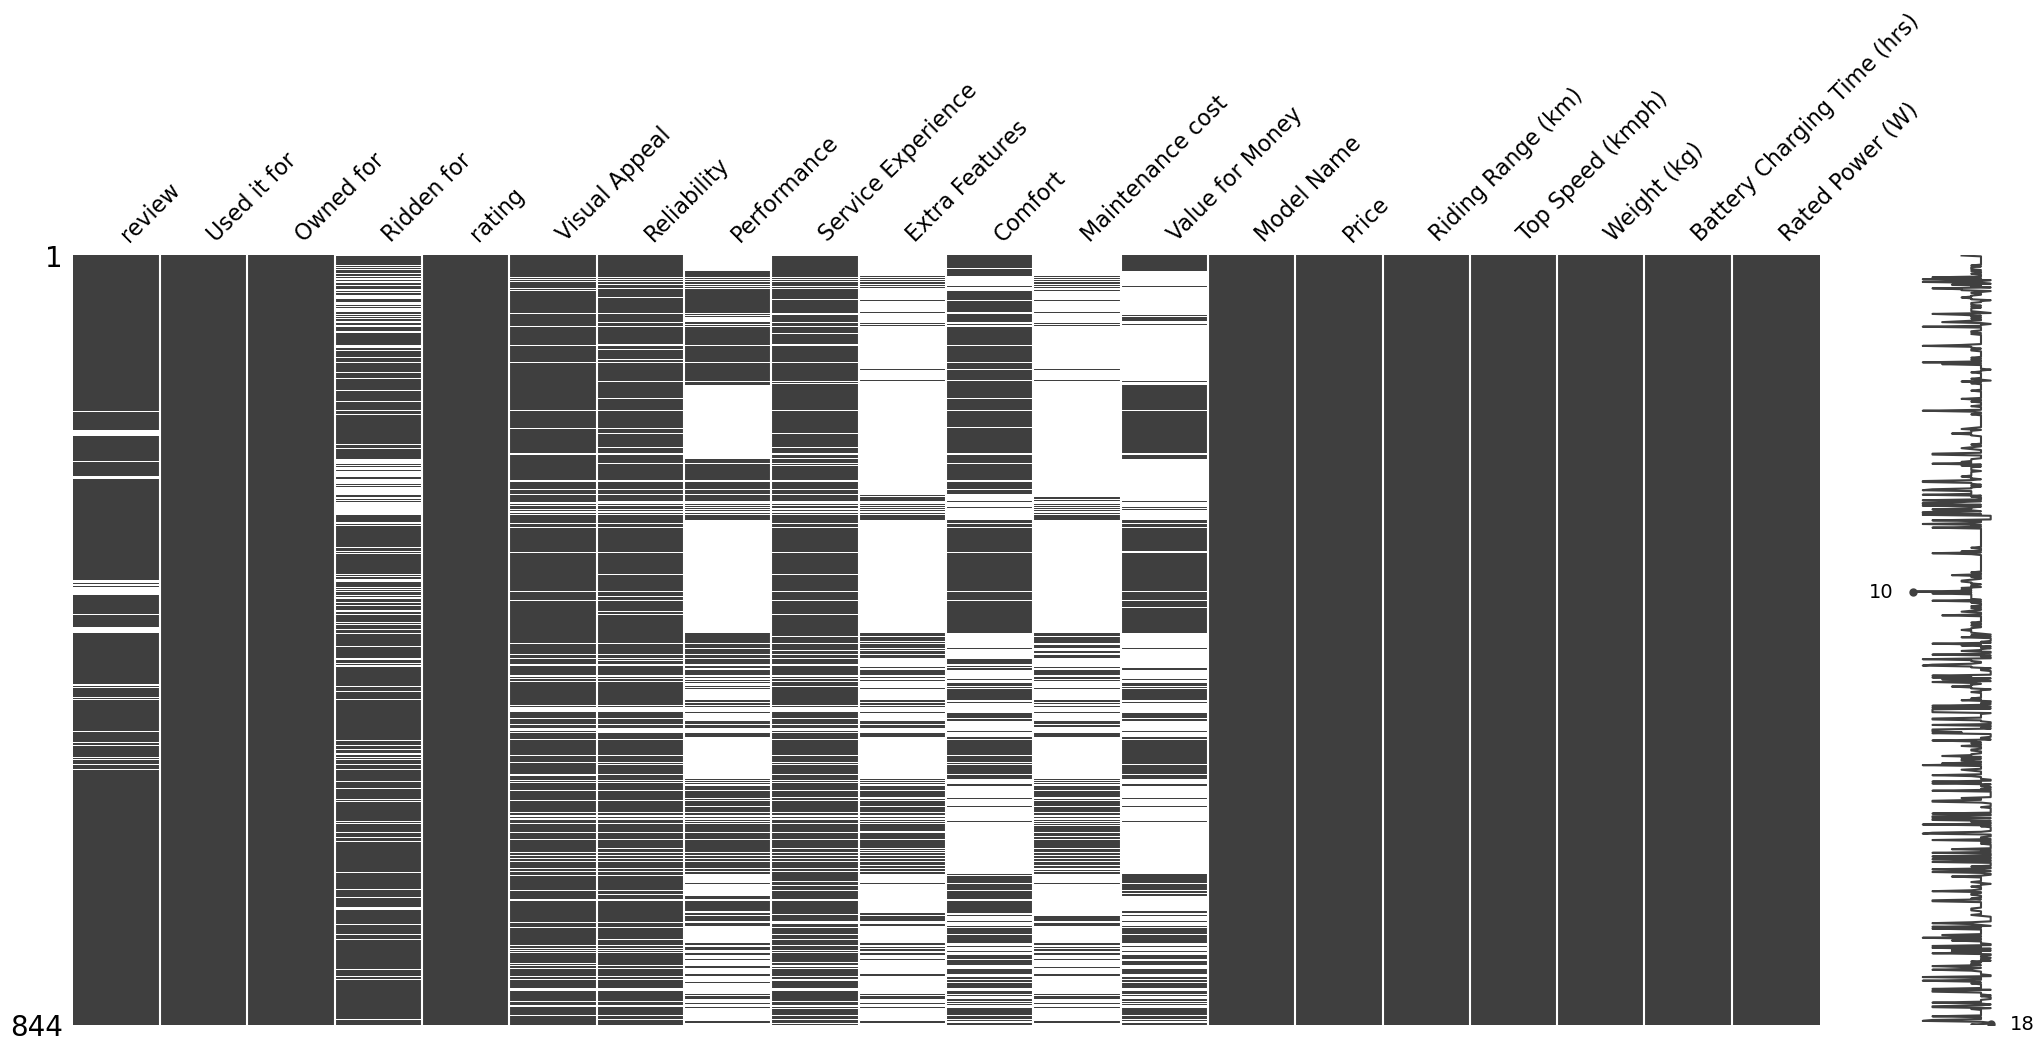

In [21]:
msno.matrix(data)

In [22]:
((data.isnull().sum() * 100/data.shape[0])).sort_values(ascending = False)

Maintenance cost               78.672986
Extra Features                 78.080569
Performance                    59.123223
Value for Money                53.791469
Comfort                        37.203791
Ridden for                     20.853081
Service Experience             16.706161
Reliability                    15.165877
Visual Appeal                  12.440758
review                          5.568720
Used it for                     0.000000
rating                          0.000000
Owned for                       0.000000
Model Name                      0.000000
Price                           0.000000
Riding Range (km)               0.000000
Top Speed (kmph)                0.000000
Weight (kg)                     0.000000
Battery Charging Time (hrs)     0.000000
Rated Power (W)                 0.000000
dtype: float64

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   review                       797 non-null    object 
 1   Used it for                  844 non-null    object 
 2   Owned for                    844 non-null    object 
 3   Ridden for                   668 non-null    object 
 4   rating                       844 non-null    int64  
 5   Visual Appeal                739 non-null    float64
 6   Reliability                  716 non-null    float64
 7   Performance                  345 non-null    float64
 8   Service Experience           703 non-null    float64
 9   Extra Features               185 non-null    float64
 10  Comfort                      530 non-null    float64
 11  Maintenance cost             180 non-null    float64
 12  Value for Money              390 non-null    float64
 13  Model Name          

In [24]:
import nltk

In [25]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Pritesh
[nltk_data]     Lanjewar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

# Example usage (assuming 'data' is your DataFrame and 'review' is the column with text data)
sentiments_list = []

for review_text in data['review']:
    if pd.isna(review_text):
        sentiments_list.append('neutral')
        continue
    sentiment_scores = sentiments.polarity_scores(review_text)

    positive_score = sentiment_scores['pos']
    negative_score = sentiment_scores['neg']

    if positive_score > negative_score:
        sentiment_label = 'positive'
    elif positive_score < negative_score:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'
        
    sentiments_list.append(sentiment_label)
    
data['sentiment'] = sentiments_list


[nltk_data] Downloading package vader_lexicon to C:\Users\Pritesh
[nltk_data]     Lanjewar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
data['sentiment'].value_counts()

sentiment
positive    527
negative    264
neutral      53
Name: count, dtype: int64

In [28]:
data_segment = data[['Used it for', 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'Performance', 'Service Experience',
       'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money',
       'sentiment']].copy()

In [29]:
data_segment.head()

,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,sentiment
0,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,negative
1,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,negative
2,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,positive
3,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,negative
4,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,negative


In [30]:
data.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube,137890,100,78,117,5,3000,negative
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,positive
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,negative


In [31]:
data_segment = data.iloc[:, 5:13].copy()

In [32]:
data_segment = data_segment.fillna(0.)

In [33]:
data_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Visual Appeal       844 non-null    float64
 1   Reliability         844 non-null    float64
 2   Performance         844 non-null    float64
 3   Service Experience  844 non-null    float64
 4   Extra Features      844 non-null    float64
 5   Comfort             844 non-null    float64
 6   Maintenance cost    844 non-null    float64
 7   Value for Money     844 non-null    float64
dtypes: float64(8)
memory usage: 52.9 KB


In [34]:
data_segment.mean()

Visual Appeal         3.309242
Reliability           2.811611
Performance           1.441943
Service Experience    2.619668
Extra Features        0.643365
Comfort               2.300948
Maintenance cost      0.723934
Value for Money       1.562796
dtype: float64

In [35]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_segment)

In [36]:
pca = PCA(random_state = 42)
pca.fit(data_scaled)

PCA(random_state=42)

In [37]:
data_pca = pca.transform(data_scaled)

In [38]:
df_pca = pd.DataFrame(data_pca, columns = [f'PC{x +1}' for x in range(len(data_segment.columns))])

In [39]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.291227,-1.038055,0.354864,-0.623469,-1.102720,-0.169287,-0.438012,0.957827
1,0.710801,-1.394405,-0.360466,-0.621671,0.320899,-0.086053,-0.426279,-0.149917
2,-0.849149,-1.189765,0.167683,-0.410898,-0.409054,-0.191904,-0.329993,0.830738
3,1.967022,-0.878935,-0.100197,0.330003,-0.075822,0.069599,0.013068,0.011328
4,0.078940,-1.017161,-0.079210,-0.324132,-0.961554,0.005517,-0.107260,0.427972


In [40]:
pca_summary = pd.DataFrame({'Standard Deviation':df_pca.std(),
                           'Proportion of Variance': pca.explained_variance_ratio_,
                           'Cumultive Proportion': pca.explained_variance_ratio_.cumsum()})

In [41]:
pca_summary

,Standard Deviation,Proportion of Variance,Cumultive Proportion
PC1,1.845017,0.425007,0.425007
PC2,1.736646,0.376546,0.801553
PC3,0.903486,0.101915,0.903468
PC4,0.517750,0.033468,0.936936
PC5,0.405239,0.020503,0.957439
PC6,0.379558,0.017987,0.975426
PC7,0.337883,0.014254,0.989680
PC8,0.287510,0.010320,1.000000


In [42]:
factor_loadings = pd.DataFrame(pca.components_, columns = data_segment.columns, index = df_pca.columns).T

In [43]:
factor_loadings.style.background_gradient(cmap = 'Blues')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Visual Appeal,-0.480170,0.117814,0.063320,-0.730598,0.247014,0.105903,0.375474,0.067539
Reliability,-0.494758,0.124910,-0.002776,0.152447,-0.819319,0.060484,0.117211,0.166384
Performance,-0.128721,0.459145,0.574833,-0.005549,-0.019902,-0.025704,-0.288468,-0.598232
Service Experience,-0.486499,0.100691,-0.054176,0.653781,0.470391,0.052432,0.311210,-0.044129
Extra Features,-0.024373,0.519633,-0.364578,-0.023208,0.116821,0.559390,-0.456829,0.246323
Comfort,-0.418255,-0.304266,0.249807,-0.020111,0.172621,-0.296656,-0.623271,0.404238
Maintenance cost,0.005912,0.513208,-0.386495,-0.054822,0.020302,-0.762039,-0.003360,0.055435
Value for Money,-0.309572,-0.351548,-0.563840,-0.107598,-0.046688,0.009572,-0.260855,-0.617065


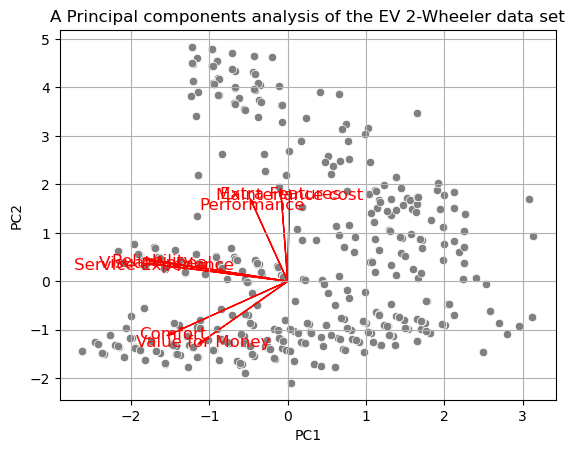

In [44]:
# Calculate centroid
index_names = factor_loadings.index

# Plot data points
sns.scatterplot(df_pca, x = 'PC1', y = 'PC2', color = 'grey')

# Plot arrows from centroid to provided coordinates with index names
for i in range(len(factor_loadings['PC1'])):
    plt.arrow(0, 0, factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i] * 3.5, head_width=0.05, head_length=0.1, fc='red', ec='red')
    plt.text((factor_loadings['PC1'][i] * 3.5), factor_loadings['PC2'][i]* 3.5, index_names[i], fontsize=12, ha='center', color = 'red', va = 'center_baseline')
   
# Set labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('A Principal components analysis of the EV 2-Wheeler data set')
plt.grid(True)
plt.show()

In [45]:
data_km28 = [KMeans(n_clusters = k, random_state = 42).fit(data_scaled) for k in range(2, 9)]

In [46]:
wcss = [model.inertia_ for model in data_km28]

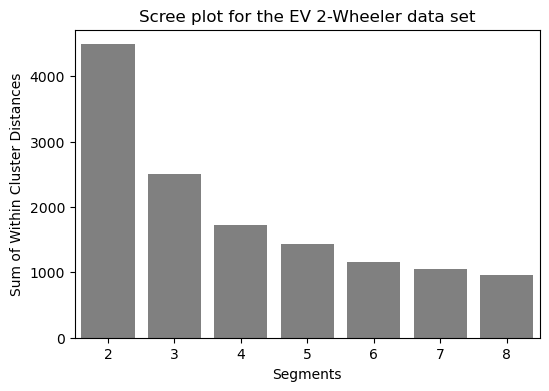

In [47]:
fig = plt.figure(figsize = (6,4))
sns.barplot(x = list(range(2, 9)), y = wcss, color = 'grey')
plt.xlabel("Segments")
plt.ylabel('Sum of Within Cluster Distances')
plt.title("Scree plot for the EV 2-Wheeler data set")
plt.show()

In [48]:
wcss_diff = pd.DataFrame({'Segments':range(2,9),
                          'WCSS Difference': pd.Series(wcss).diff()})
wcss_diff['WCSS Difference'][0] = 0

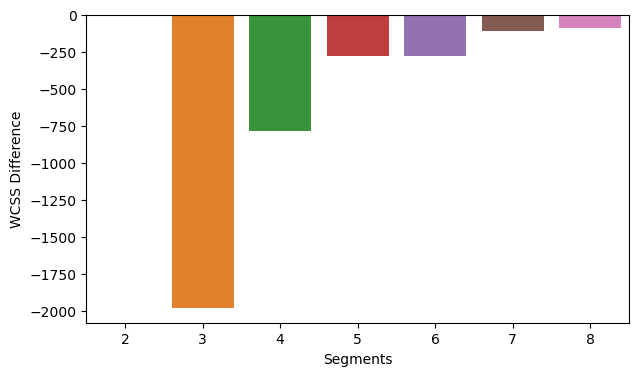

In [49]:
plt.figure(figsize = (7, 4))
sns.barplot(wcss_diff, x = 'Segments', y = 'WCSS Difference')
plt.show()

The decision-making process was significantly guided by the scree plot above, revealing a distinct elbow at four segments. This marked point indicated a substantial reduction in distances, signifying the optimal number of segments for our analysis.

In [50]:
kmeans = data_km28[2]

In [51]:
data_clust = pd.DataFrame(data_scaled, columns = data_segment.columns)
data_clust['cluster'] = kmeans.labels_

In [52]:
data_pca = df_pca.copy()
data_pca['cluster'] = kmeans.labels_

# Profiling Segments

In [53]:
data_profile = data_segment.copy()
data_profile['cluster'] = kmeans.labels_

In [54]:
columns_segment = data_clust.columns
data_pivot = data_profile[columns_segment].groupby('cluster').mean().T

In [55]:
data_pivot_mean = data_pivot.mean(axis = 1).reset_index()
data_pivot_mean.columns = ['Variable', 'Value']

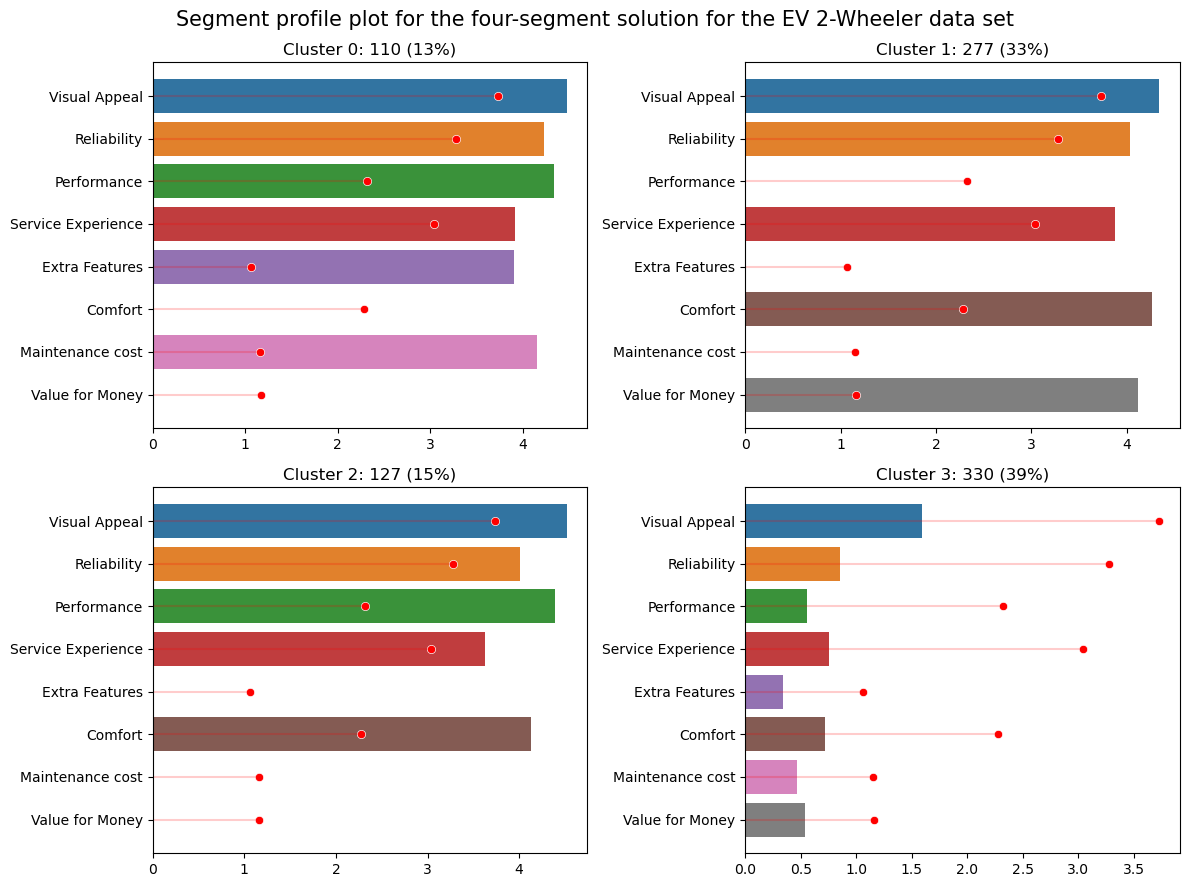

In [56]:
plt.figure(figsize = (12, 9))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.barplot(data_pivot, x = i, y = data_pivot.index)
    sns.scatterplot(data_pivot_mean, x = 'Value', y = 'Variable', color = 'red')
    for index, row in data_pivot_mean.iterrows():
        plt.hlines(y=row['Variable'], xmin=0, xmax=row['Value'], colors='red', alpha = 0.2)
    plt.ylabel("")
    plt.xlabel("")
    plt.title(f"Cluster {i}: {data_profile['cluster'].value_counts()[i]} ({data_profile['cluster'].value_counts()[i]*100/len(data_profile):.0f}%)")
plt.suptitle("Segment profile plot for the four-segment solution for the EV 2-Wheeler data set", fontsize = 15)
plt.tight_layout()
plt.show()

Above graph visually captures the diverse perceptions among different segments. Segment 0, representing 13% of consumers, values the electric two-wheeler vehicle for its visual appeal, reliability, performance, service experience, and comfort. Conversely, Segment 1 (33% of consumers) expresses dissatisfaction across all aspects, marking them as the largest but least satisfied group. Segment 2 (15% of consumers) appreciates visual appeal, reliability, service experience, comfort, and notably, perceives a strong value for money. Lastly, Segment 3 (39% of consumers), the smallest segment, values visual appeal, reliability, performance, service experience, extra features, and maintenance cost, showcasing distinct perceptions, particularly on features and costs.

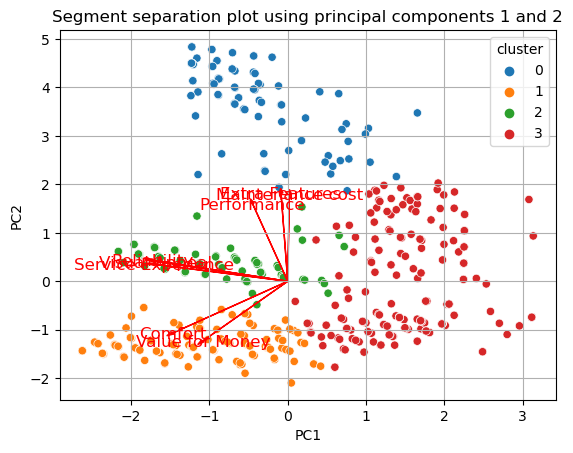

In [57]:
# Calculate centroid
index_names = factor_loadings.index

# Plot data points
sns.scatterplot(data_pca, x = 'PC1', y = 'PC2', hue = 'cluster', palette = 'tab10')

# Plot arrows from centroid to provided coordinates with index names
for i in range(len(factor_loadings['PC1'])):
    plt.arrow(0, 0, factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i] * 3.5, head_width=0.05, head_length=0.1, fc='red', ec='red')
    plt.text(factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i]* 3.5, index_names[i], fontsize=12, ha='center', color = 'red', va = 'center_baseline')

# Set labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Segment separation plot using principal components 1 and 2')
plt.grid(True)
plt.show()

Above Figure, utilizing principal components, further emphasizes the differences among segments. Notably, Segment 3, despite being the largest segment, lacks specific opinions, making them unique in their lack of satisfaction.

# Describing Segments/Analysis

In [58]:
data_desc = data.copy()
data_desc['cluster'] = kmeans.labels_

In [59]:
data_desc.columns

Index(['review', 'Used it for', 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'Performance', 'Service Experience',
       'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money',
       'Model Name', 'Price', 'Riding Range (km)', 'Top Speed (kmph)',
       'Weight (kg)', 'Battery Charging Time (hrs)', 'Rated Power (W)',
       'sentiment', 'cluster'],
      dtype='object')

In [60]:
def mosaicplot(df, color_list, figsize=(5,5), barwidth = 1, title = "Simple Mosaic Plot", xlabel = 'cat'):
    
    fig, ax = plt.subplots(figsize =figsize)
    
    # Convert to ratio of each row sum and do a cumsum along row
    p_cnt_ratio_df = df.div(df.sum(1), axis =0)
    ratio_cum_df = p_cnt_ratio_df.cumsum(axis=1)
    
    # Get column order.
    col_order = ratio_cum_df.columns.tolist()
        
    x = [str(n) for n in ratio_cum_df.index.tolist()]
    
    # Do the actual plots
    for col, colour in zip(col_order[::-1], color_list):
        plt.bar(x, ratio_cum_df[col], color=colour, edgecolor='white', width=barwidth, label=col)
        
    # Add in legend
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    
    # Configure title and axis
    plt.title(title)
    plt.xlabel("Segments")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks([])
    plt.show()
    

In [61]:
color_list = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F']

In [62]:
sentiment_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['sentiment'])

In [63]:
sentiment_cluster

sentiment,negative,neutral,positive
cluster,,,
0,17,0,93
1,30,41,206
2,13,4,110
3,204,8,118


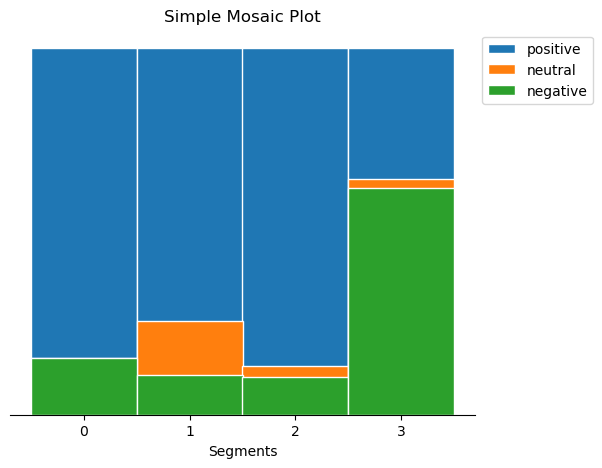

In [64]:
mosaicplot(sentiment_cluster, color_list[:3], figsize=(6,5), barwidth = 1)

Above mosaic plot, explores consumer sentiments, revealing that all segments, except Segment 3, exhibit positive sentiments. Segment 3 consumers stand out with negative sentiments, indicating dissatisfaction across various aspects.

In [65]:
used_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Used it for'])

In [66]:
used_cluster

Used it for,Daily Commute,Everything,Leisure Rides,Occasional Commute,Tours
cluster,,,,,
0,87,19,2,1,1
1,194,55,7,19,2
2,75,39,4,9,0
3,244,47,7,27,5


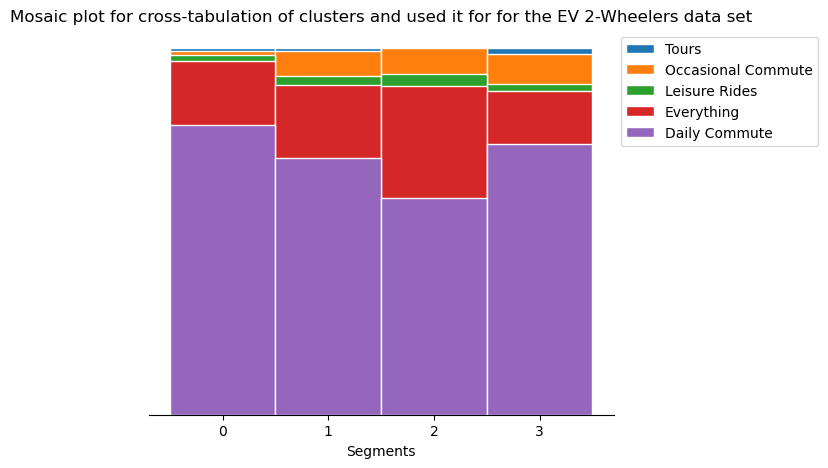

In [67]:
mosaicplot(used_cluster, color_list[:5], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and used it for for the EV 2-Wheelers data set' )

Above mosaic plot illustrates that all segments predominantly use electric vehicles for daily commuting, with limited usage for tours, occasional commuting, and leisure rides

In [68]:
owned_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Owned for'])

In [69]:
owned_cluster

Owned for,3-6 months,6 months-1 yr,< 3 months,> 1 yr,Never owned,Occasional Commute
cluster,,,,,,
0,14,14,43,20,19,0
1,41,51,79,56,50,0
2,16,14,31,10,56,0
3,40,55,67,117,50,1


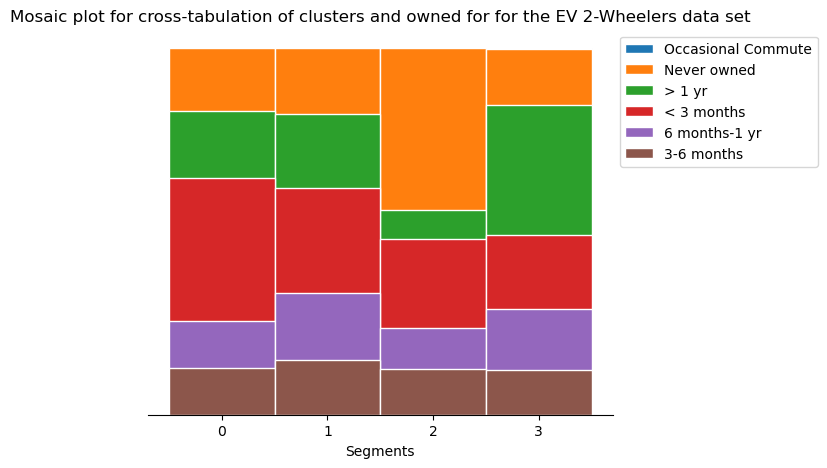

In [70]:
mosaicplot(owned_cluster, color_list[:6], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and owned for for the EV 2-Wheelers data set' )

Above mosaic plot delineates the ownership duration of electric vehicles among segments. Segment 3 stands out, owning electric vehicles for more than a year, while Segment 2 has no prior ownership experience. Segment 1 members moderately own vehicles ranging from less than 3 months to over a year, and Segment 0 consumers have owned electric vehicles for a few days to less than 3 months.

In [71]:
ridden_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Ridden for'])

In [72]:
ridden_cluster

Ridden for,10000-15000 kms,5000-10000 kms,< 5000 kms,> 15000 kms,Never owned
cluster,,,,,
0,5,18,63,5,0
1,11,44,158,14,0
2,1,15,54,1,0
3,15,61,184,18,1


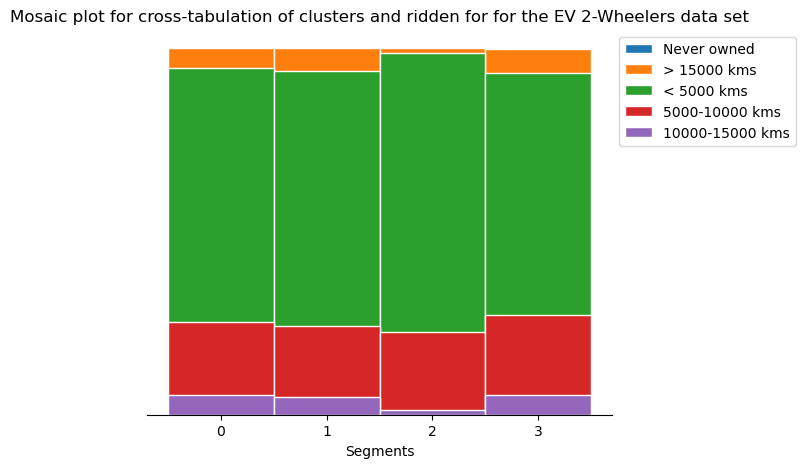

In [73]:
mosaicplot(ridden_cluster, color_list[:5], figsize=(6,5), barwidth = 1, title = 'Mosaic plot for cross-tabulation of clusters and ridden for for the EV 2-Wheelers data set' )

Above mosaic plot delves into the distances covered by consumers, indicating that all segments predominantly use electric vehicles for commuting, with most users covering distances below 5000 kms. A small portion falls in the 5000 to 10000 kms range, aligning with their commuting needs

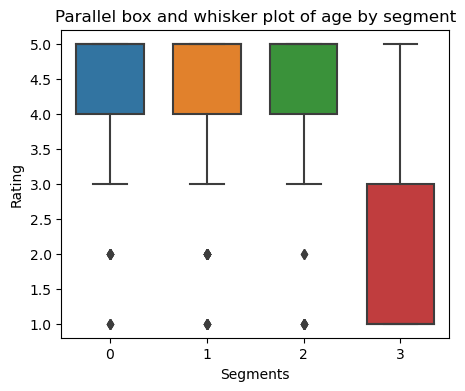

In [74]:
# Number of cluster along the x-axis and rating along the y-axis
plt.figure(figsize = (5,4))
sns.boxplot(data_desc, x= 'cluster', y = 'rating', palette = 'tab10', width = 0.7)
plt.xlabel("Segments")
plt.ylabel("Rating")
plt.title("Parallel box and whisker plot of age by segment")
plt.savefig("rating.png")
plt.show()

Above parallel box and whisker plot, emphasizes significant differences in average ratings among segments. Specifically, Segment 3 consumers express dissatisfaction across all perceptions, leading to lower overall ratings.

In [75]:
data_desc.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment,cluster
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative,3
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube,137890,100,78,117,5,3000,negative,3
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,positive,1
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative,3
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,negative,1


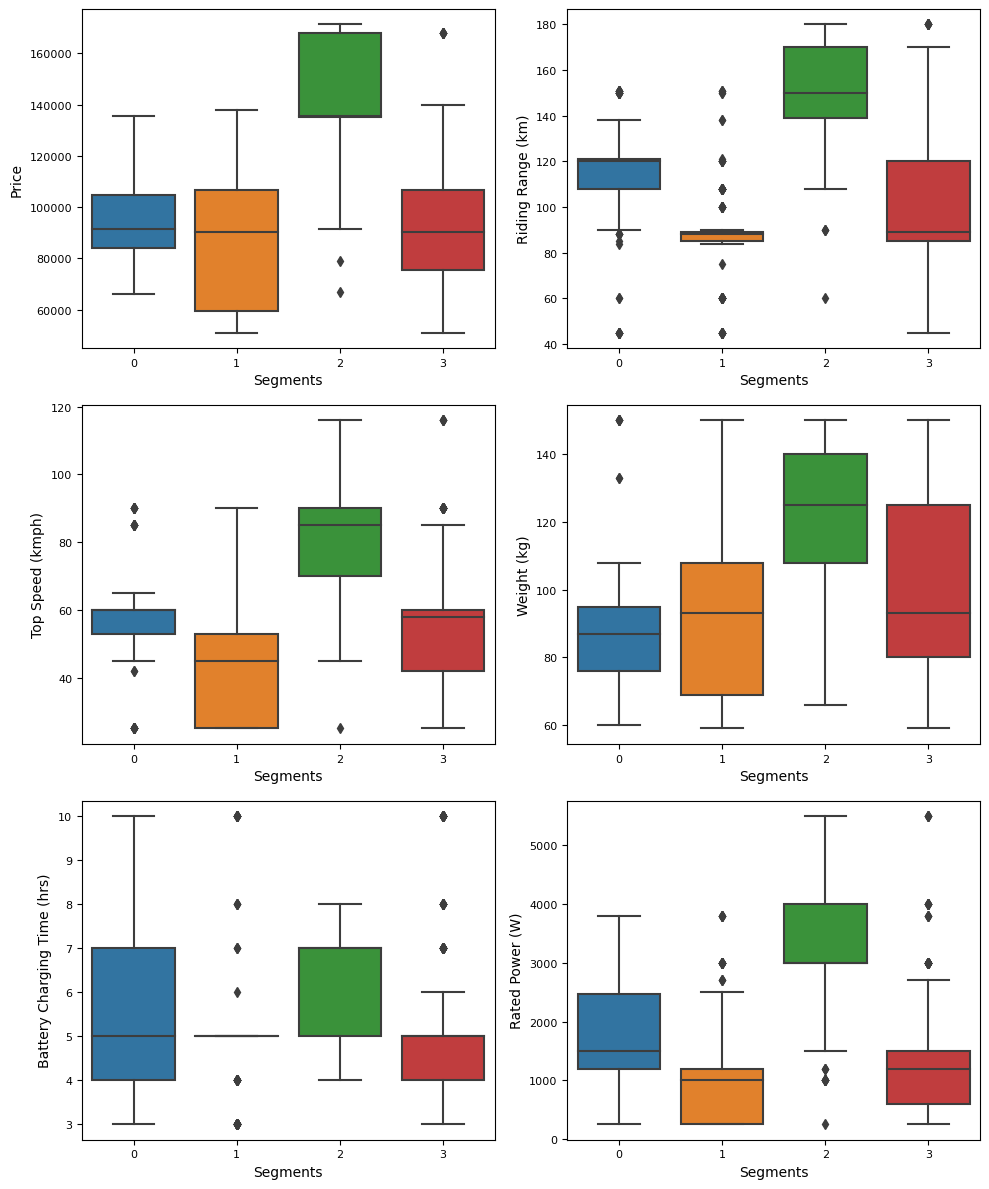

In [76]:
plt.figure(figsize = (10, 12))
for i, col in enumerate(data_desc.columns[-8:-2]):
    plt.subplot(3, 2, i+1)
    sns.boxplot(data_desc, x = 'cluster', y =col)
    plt.xlabel("Segments", fontsize= 10)
    plt.ylabel(col, fontsize = 10)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.show()

In analyzing technical specification of electric vehicles across different segments, distinct patterns emerge. Segment 2 prefers premium EVs with a higher price range and extended riding range, emphasizing consumer preference for luxury and long-distance travel. Segment 2 focuses on budget-friendly options with lower prices and moderate riding ranges, suitable for daily commuting. Segment 2 and Segment 3 prioritize affordability, with slight differences in riding range and speed preferences. Weight preferences vary, with Segment 2 and Segment 3 favoring heavier vehicles, while Segment 0 and Segment 1 prefer lighter options. Charging time also differs, with Segment 0 and Segment 2 opting for longer durations for overnight charging, while Segment 1 and Segment 2 prioritize faster charging for quick turnaround times. These nuanced preferences shape the electric vehicle market in India.